# <center> 🦟 $DengAI: Predicting\ Disease\ Spread\$

## <center> $Григорий\ Хомюк\$
    
<img src='images/rank.png' />

<div class="alert alert-info">

Данная работа основана на соревновании: **https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/**
    
---
    
**Акцент** в исследовании сделан на ***feature engineering***, ***визуализацию признаков и прогнозов для временных рядов***, и ***тюнинг `CatBoostRegressor`***. Также были обучены `Lasso`, `RandomForest`. `SARIMAX` давал плохие прогнозы, поэтому в работе не представлен.
    
---   
    
**Задача**: Можете ли вы, используя данные об окружающей среде, собранные федеральными правительственными агентствами США, **предсказать число случаев лихорадки денге*, регистрируемых каждую неделю** в Сан-Хуане, Пуэрто-Рико, и Икитосе, Перу??
    
---
#### $Метрика\ качества$: ***MAE***

<div class="alert alert-info">

### data description: 

`city` – Сокращения городов: ***sj*** для Сан-Хуана и ***iq*** для Икитоса
    
`week_start_date` – Дата указана в формате гггг-мм-дд

Все климатические показатели и целевая переменная (кол-во заражений) измерены понедельно.

#### * Ежедневные измерения климатических данных GHCN NOAA
`station_max_temp_c` – Максимальная температура
    
`station_min_temp_c` – Минимальная температура
    
`station_avg_temp_c` – Средняя температура
    
`station_precip_mm` – Общее количество осадков
    
`station_diur_temp_rng_c` – Суточный диапазон температур

#### * Спутниковые измерения осадков PERSIANN (шкала 0,25x0,25 градуса)
`precipitation_amt_mm` – Общее количество осадков
    
#### * Система повторного анализа климатических прогнозов NCEP NOAA (шкала 0,5x0,5 градуса)    

`reanalysis_sat_precip_amt_mm` – Общее количество осадков
    
`reanalysis_dew_point_temp_k` – Средняя температура точки росы
    
`reanalysis_air_temp_k` – Средняя температура воздуха 
    
`reanalysis_relative_humidity_percent` – Средняя относительная влажность
    
`reanalysis_specific_humidity_g_per_kg` – Средняя удельная влажность
    
`reanalysis_precip_amt_kg_per_m2` – Общее количество осадков
    
`reanalysis_max_air_temp_k` – Максимальная температура воздуха
    
`reanalysis_min_air_temp_k` – Минимальная температура воздуха
    
`reanalysis_avg_temp_k` – Средняя температура воздуха
    
`reanalysis_tdtr_k` – Диапазон суточных температур
    
#### * Спутниковая растительность - Нормализованный индекс разности растительности (NDVI) - Измерения CDR NOAA Normalized Difference Vegetation Index (шкала 0,5x0,5 градуса)

`ndvi_se` – Пиксель к юго-востоку от городского центроида
    
`ndvi_sw` – Пиксель к юго-западу от городского центроида
    
`ndvi_ne` – Пиксель к северо-востоку от городского центроида
    
`ndvi_nw` – Пиксель к северо-западу от городского центроида

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import prod
from itertools import product
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sm

%pylab inline

In [2]:
test = pd.read_csv('data/DengAI_Predicting_Disease_Spread_-_Test_Data_Features.csv', sep=',')
train = pd.read_csv('data/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv', sep=',')
labels = pd.read_csv('data/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv', sep=',')
label = labels['total_cases']
train['target'] = label

In [3]:
pd.set_option('display.max_columns', None)
train.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
0  0.177617                 12.42             297.572857   
1  0.155486                 22.82             298.211429   
2  0.170843                 34.54             298.781429   
3  0.235886                 15.36             298.987143   
4  0.247340                  7.52             299.518571   

   reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
0             297.742857                   292.414286   
1             298.442857                   293.951429   
2             298.878571                   295.434286   
3             299.228571                   295.310000   
4             299.664286                   295.821429   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                      299.8                      295.9   
1                      300.9                      296.4   
2                      300.5                      297.3   
3                      301.4                      297.0   
4                      301.9                      297.5   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   
3                            13.90                             80.337143   
4                            12.20                             80.460000   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012857   
1                         22.82                              15.372857   
2                         34.54                              16.848571   
3                         15.36                              16.672857   
4                          7.52                              17.210000   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           2.628571           25.442857                 6.900000   
1           2.371429           26.714286                 6.371429   
2           2.300000           26.714286                 6.485714   
3           2.428571           27.471429                 6.771429   
4           3.014286           28.942857                 9.371429   

   station_max_temp_c  station_min_temp_c  station_precip_mm  target  
0                29.4                20.0               16.0       4  
1                31.7                22.2                8.6       5  
2                32.2                22.8               41.4       4  
3                33.3                23.3                4.0       3  
4                35.0                23.9                5.8       6

#### $ Как\ ведёт\ себя\ вообще\ заболеваемость$ `total_cases` $во\ времени\ ? $

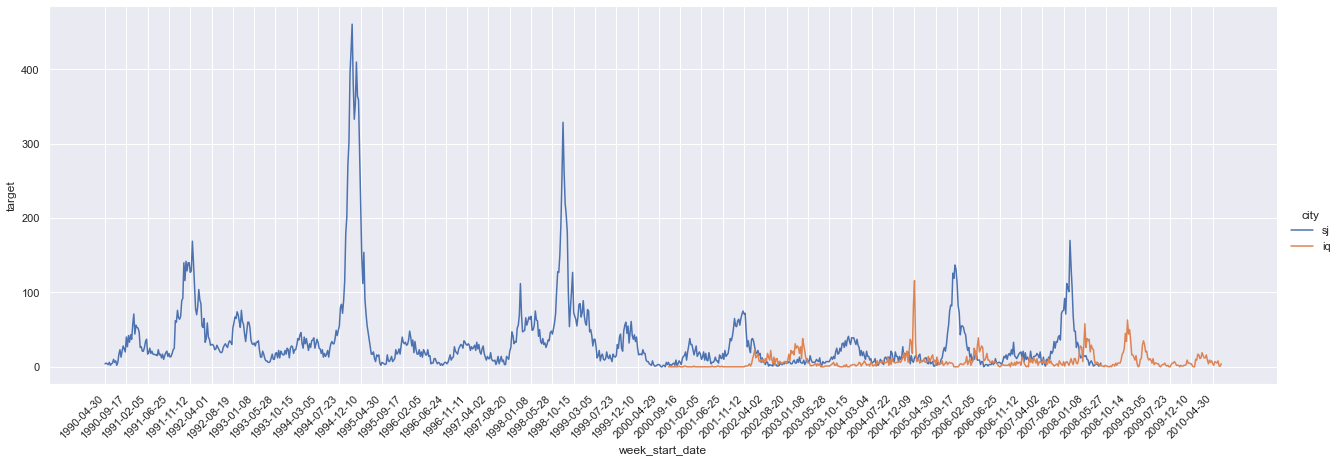

In [4]:
g = sns.relplot(data=train, x="week_start_date", y="target", hue="city",
                legend=True, kind="line", aspect=3, height=6)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=20)

#### $ Можно\ наложить\ какой-нибудь\ признак\ на\ таргет\ и\ попытаться\ увидеть\ зависимость:\ $

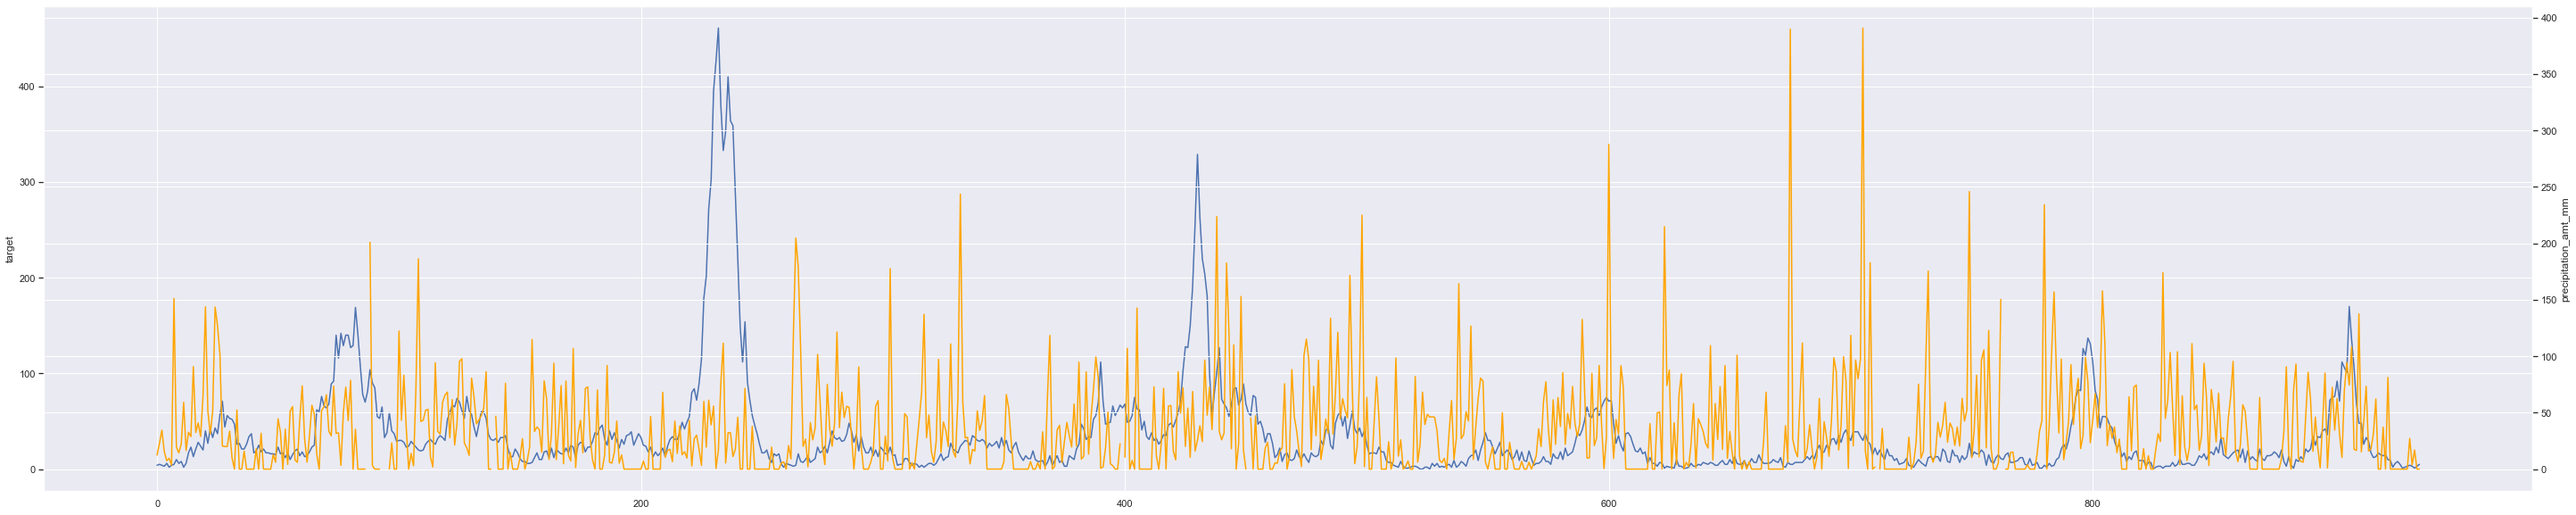

In [5]:
fig, ax1 = plt.subplots(figsize=(50, 10))
ax2 = ax1.twinx()
ax1.plot(train.loc[train.city=='sj', 'target'], label= 'Target')
ax2.plot(train.loc[train.city=='sj', 'precipitation_amt_mm'], label = 'Feature', color='orange')
ax1.set_ylabel('target')
ax2.set_ylabel('precipitation_amt_mm')
plt.show()

# <center> Train-Validation Split 🌓

<div class="alert alert-info">

При разделении данных на обучающую и тестовую выборки для временных рядов важно учитывать временную природу данных. В отличие от стандартного подхода, при котором данные могут быть случайно разбиты на обучающие и тестовые, данные временных рядов нужно разделять с учетом последовательности времени.

Разделим данные на обучение и валидацию:

In [6]:
train.loc[train['city'] == 'sj']['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008])

In [7]:
train.loc[train['city'] == 'iq']['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

Для города `city='sj'` *San Juan* возьмём на валидацию период следующих лет ***[2005, 2006, 2007, 2008]***.

Для города `city='iq'` *Iquitos* возьмём на валидацию период следующих лет ***[2008, 2009, 2010]***.

Создадим столбец `sample` принимающий значение *train | test* для разделения выборки.

In [8]:
train['sample'] = 'train'
train.loc[(train['year'].isin([2005, 2006, 2007, 2008])) & (train['city']=='sj'), 'sample'] = 'test'
train.loc[(train['year'].isin([2008, 2009, 2010])) & (train['city']=='iq'), 'sample'] = 'test'   # .loc[()&(), i]

In [9]:
TRAIN = train.drop(columns=['weekofyear', 'year', 'week_start_date']) 
TEST = test.drop(columns=['year', 'weekofyear', 'week_start_date'])

In [10]:
features = list(TRAIN.columns)[1:-2]

In [11]:
features

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

- Для какого города прогнозируем заболеваемость – имеет значение. В разных городах разные признаки оказываются значимыми, поэтому **для разных городов – будут разные модели**.

In [12]:
# Разделим трэйн и тест для двух разных городов
TRAIN_SJ = TRAIN.loc[TRAIN['city']=='sj'].reset_index(drop=True).drop(columns=['city'])
TRAIN_IQ = TRAIN.loc[TRAIN['city']=='iq'].reset_index(drop=True).drop(columns=['city'])
TEST_SJ = TEST.loc[TEST['city']=='sj',:].reset_index(drop=True).drop(columns=['city'])
TEST_IQ = TEST.loc[TEST['city']=='iq',:].reset_index(drop=True).drop(columns=['city'])

# <center> Preprocessing and Feature Engineering 🧠

- **Пропуски** в данных **заполним средним** арифметическим по соответствующему столбцу. Валидация/тест показали, что это лучше, чем заполнением нулём.

In [13]:
# заполнение пропусков средним
TRAIN_SJ.fillna(TRAIN_SJ.iloc[:,:-2].mean(), inplace=True)
TRAIN_IQ.fillna(TRAIN_IQ.iloc[:,:-2].mean(), inplace=True)
TEST_SJ.fillna(TRAIN_SJ.iloc[:,:-2].mean(), inplace=True) 
TEST_IQ.fillna(TRAIN_IQ.iloc[:,:-2].mean(), inplace=True) 

## $ Features $ 🚀
- Создадим на основе климатических данных (20 показателей) новые признаки: лаги / агрегации на основе значений предыдущих недель с разными временными окнами:
<br>

    - Климатические данные ✅
    - Таргет с лагом 1 ✅
    - Климатические данные с лагом 1 ✅
    - Климатические данные с лагом 2 ✅
    - Max(показатель) за прошлые 4 и 8 недель ✅
    - Max(показатель) - Min(показатель) за прошлые 4 и 8 недель ✅
    - Дисперсия показателя за прошлые 4 и 8 недель ✅
    - Кол-во перегибов показателя за последние 4 и 8 недель ✅

In [14]:
# Функция для подсчета перегибов
def count_turns(series):
    turns = 0
    series = series.reset_index(drop=True)
    for i in range(1, len(series) - 1):
        if (series[i] - series[i - 1]) * (series[i + 1] - series[i]) < 0:
            turns += 1
    return turns

# Ф-ция возвращает df уже с признаками "кол-во перегибов/максимум/среднее и т.д. за предыдущие steps недель"
def feature_engineering(df, features, steps):
    features_turns = [i+'_turns_'+str(steps) for i in features]
    features_max = [i+'_max_'+str(steps) for i in features]
    features_mean = [i+'_mean_'+str(steps) for i in features]
    features_var = [i+'_var_'+str(steps) for i in features]
    features_diff_max_min = [i+'_diff_max_min_'+str(steps) for i in features]
    
    df_turns = pd.DataFrame(np.zeros((df.shape[0], len(features))), columns=features_turns)
    df_max = pd.DataFrame(np.zeros((df.shape[0], len(features))), columns=features_max)
    df_mean = pd.DataFrame(np.zeros((df.shape[0], len(features))), columns=features_mean)
    df_var = pd.DataFrame(np.zeros((df.shape[0], len(features))), columns=features_var)
    df_diff_max_min = pd.DataFrame(np.zeros((df.shape[0], len(features))), columns=features_diff_max_min)

    for ind, j in enumerate(features):
        turns_list = []
        max_list = []
        mean_list = []
        var_list = []
        diff_max_min_list = []
        
        for i in range(len(df)):
            if i < steps-1:
                turns_list.append(np.nan)
                max_list.append(np.nan)
                mean_list.append(np.nan)
                var_list.append(np.nan)
                diff_max_min_list.append(np.nan)
            else:
                turns_list.append(count_turns(df[j][i-(steps-1):i+1]))
                max_list.append(df[j][i-(steps-1):i+1].max())
                mean_list.append(df[j][i-(steps-1):i+1].mean())
                var_list.append(df[j][i-(steps-1):i+1].var())
                diff_max_min_list.append(df[j][i-(steps-1):i+1].max() - df[j][i-(steps-1):i+1].min())

        df_turns.iloc[:, ind] = turns_list
        df_max.iloc[:, ind] = max_list
        df_mean.iloc[:, ind] = mean_list
        df_var.iloc[:, ind] = var_list
        df_diff_max_min.iloc[:, ind] = diff_max_min_list

        df.reset_index(drop=True, inplace=True)
    return pd.concat([df, df_turns, df_max, df_mean, df_var, df_diff_max_min], axis=1)

In [15]:
# создание признаков ~ кол-во перегибов/максимум/среднее/макс-мин с временным окном 8 недель
TEST_SJ = feature_engineering(pd.concat([TRAIN_SJ[features].iloc[-7:], TEST_SJ],axis=0), features, 8)
TEST_IQ = feature_engineering(pd.concat([TRAIN_IQ[features].iloc[-7:], TEST_IQ],axis=0), features, 8)
TRAIN_SJ = feature_engineering(TRAIN_SJ, features, 8)
TRAIN_IQ = feature_engineering(TRAIN_IQ, features, 8)
TEST_SJ = TEST_SJ[7:].reset_index(drop=True)
TEST_IQ = TEST_IQ[7:].reset_index(drop=True)

In [16]:
# создание признаков ~ кол-во перегибов/максимум/среднее/макс-мин с временным окном 4 недель
TEST_SJ = feature_engineering(pd.concat([TRAIN_SJ[features].iloc[-3:], TEST_SJ],axis=0), features, 4)
TEST_IQ = feature_engineering(pd.concat([TRAIN_IQ[features].iloc[-3:], TEST_IQ],axis=0), features, 4)
TRAIN_SJ = feature_engineering(TRAIN_SJ, features, 4)
TRAIN_IQ = feature_engineering(TRAIN_IQ, features, 4)
TEST_SJ = TEST_SJ[3:].reset_index(drop=True)
TEST_IQ = TEST_IQ[3:].reset_index(drop=True)

In [17]:
# Создадим списки названий признаков:
features_lag_1 = [i+'_lag_1' for i in features]
features_lag_2 = [i+'_lag_2' for i in features]
# features_lag_3 = [i+'_lag_3' for i in features]

In [18]:
# Создадим лаг 1 таргета target_lag_1
TRAIN_SJ['target_lag_1'] = TRAIN_SJ['target'].shift(1)
TRAIN_IQ['target_lag_1'] = TRAIN_IQ['target'].shift(1)
TEST_SJ.loc[0, 'target_lag_1'] = 5
TEST_IQ.loc[0, 'target_lag_1'] = 4

In [19]:
# Создадим лаг 1 климатических данных
TRAIN_SJ[features_lag_1] = TRAIN_SJ[features].shift(1)
TRAIN_IQ[features_lag_1] = TRAIN_IQ[features].shift(1)
TEST_SJ[features_lag_1] = TEST_SJ[features].shift(1)
TEST_IQ[features_lag_1] = TEST_IQ[features].shift(1)

In [20]:
# Создадим лаг 2 климатических данных
TRAIN_SJ[features_lag_2] = TRAIN_SJ[features].shift(2)
TRAIN_IQ[features_lag_2] = TRAIN_IQ[features].shift(2)
TEST_SJ[features_lag_2] = TEST_SJ[features].shift(2)
TEST_IQ[features_lag_2] = TEST_IQ[features].shift(2)

In [21]:
# Заполним предыдущими значениями сдвиги в тесте
TEST_SJ.loc[0, features_lag_1] = TRAIN_SJ.loc[935,features].values
TEST_SJ.loc[0, features_lag_2] = TRAIN_SJ.loc[934,features].values
TEST_SJ.loc[1, features_lag_2] = TRAIN_SJ.loc[935,features].values
TEST_IQ.loc[0, features_lag_1] = TRAIN_IQ.loc[519,features].values
TEST_IQ.loc[0, features_lag_2] = TRAIN_IQ.loc[518,features].values
TEST_IQ.loc[1, features_lag_2] = TRAIN_IQ.loc[519,features].values

In [22]:
# pd.set_option('display.max_columns', None)
TRAIN_SJ['target_lag_1'].mean() 

34.21176470588235

- **Стандартизация данных** – важная часть предобработки данных, особенно для линейных моделей, она повышает качество.

In [23]:
# стандартизовали данные
scaler_sj = StandardScaler()
TRAIN_SJ[TEST_SJ.columns] = scaler_sj.fit_transform(TRAIN_SJ[TEST_SJ.columns])
TEST_SJ[TEST_SJ.columns] = scaler_sj.transform(TEST_SJ[TEST_SJ.columns])

scaler_iq = StandardScaler()
TRAIN_IQ[TEST_IQ.columns] = scaler_iq.fit_transform(TRAIN_IQ[TEST_IQ.columns])
TEST_IQ[TEST_IQ.columns] = scaler_iq.transform(TEST_IQ[TEST_IQ.columns])

In [24]:
TRAIN_SJ.columns.get_loc('target_lag_1')

222

Вычленим среднее и стандартное отклонение лага таргета для обоих городов, чтобы при прогнозировании теста, руками сразу стандартизовывать значение. 

In [25]:
# 220 берём потому что мы не стандартизовывали два столбца: target и sample
mean_target_sj = scaler_sj.mean_[220]
scale_target_sj = scaler_sj.scale_[220] 
mean_target_iq = scaler_iq.mean_[220]
scale_target_iq = scaler_iq.scale_[220]
print(mean_target_sj, scale_target_sj, mean_target_iq, scale_target_iq)

34.21176470588235 51.3725000884229 7.572254335260116 10.764338509632495


In [26]:
# Первые строки в трэйне будут с пропусками, удалим их
TRAIN_SJ = TRAIN_SJ.dropna().reset_index(drop=True)
TRAIN_IQ = TRAIN_IQ.dropna().reset_index(drop=True)

In [976]:
# features ~ климатические показатели (20шт)
# month_features ~ дамми месячные (13шт)
# features_lag_1 ~ климатические показатели с лагом 1 (20шт)
# features_lag_2 ~ климатические показатели с лагом 2 (20шт)
# ['target_lag_1'] ~ лаг 1 таргета

# <center> Hyperparameter Tuning on Validation 🌪️

- Как уже было оговорено, воспользуемся простым подходом с фиксированным разбиением `(Fixed Window Approach)` – будем подбирать гиперпараметры на валидационной выборке, которую получили ранее.

***Обозначаем на каких признаках и с каким городом работаем:***

In [858]:
feat = features_best100 #features+['target_lag_1']+month_features+features_lag_1+features_lag_2 #+['target_lag_1']   # lasso_features # features+['target_lag_1'] #+month_features+features_lag_1+features_lag_2+['target_lag_1']  #+month_features+features_lag_1+features_lag_2+['target_lag_1'] #+['target_lag_1'] # #+month_features+features_lag_1+features_lag_2   
X = TRAIN_SJ # TRAIN_IQ # TRAIN_SJ

In [833]:
X_train = X.loc[X['sample']=='train'].drop(columns=['target','sample']).reset_index(drop=True)
X_test = X.loc[X['sample']=='test'].drop(columns=['target','sample']).reset_index(drop=True) 
y_train = X.loc[X['sample']=='train', 'target'].reset_index(drop=True)
y_test = X.loc[X['sample']=='test', 'target'].reset_index(drop=True)
mean_target = mean_target_sj # mean_target_iq
scale_target = scale_target_sj # scale_target_iq

In [137]:
param_grid = {
    "iterations": [40, 47, 58, 65, 70, 85, 100,120,140],           
     "depth":         [4,5,6,7,8,9,11],            
#      "learning_rate": [0.005, 0.008, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.07],                   
} 
best_mae, best_mse, best_params = float('inf'), float('inf'), 0

train_dataset = Pool(data=X_train, label=y_train) 
eval_dataset = Pool(data=X_test, label=y_test) 

all_values = list(param_grid.values())
for i, parameters in enumerate(product(*all_values)):
    
    params = dict(zip(param_grid.keys(), parameters))
    
    model = CatBoostRegressor(**params, verbose=1, loss_function='RMSE') 

    model.fit(train_dataset, verbose=0, use_best_model=False, plot=False) #eval_set=eval_dataset 

    predicts = []

    for i in range(len(X_test)):
        predict = model.predict(X_test.loc[i:i, :])[0]
        predicts.append(predict)
        if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
            X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target)/ scale_target

    y_hat = [int(arr) if arr > 0 else 0 for arr in predicts] 
    mae = mean_absolute_error(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat) 
    if mse < best_mse:
        best_mae = mae
        best_mse = mse
        best_params = params
    print(f"{params}: MSE: {mse} MAE: {mae}")
print(f'BEST MODEL CATBOOST: {best_params} with MSE = {best_mse} MAE = {best_mae}') 

- Обучим некоторые модели, построим графики прогнозов этих моделей на валидации и тесте. Некоторые модели обучим не на всём признаковом пространстве, а на лучших признаках, которые были отобраны с помощью `Catboost` и метода `feature_importance` по всей обучающей выборке. 

# Forecast on Validation

## San Juan

In [31]:
y_train = TRAIN_SJ.loc[TRAIN_SJ['sample']=='train', 'target'].reset_index(drop=True)
y_test = TRAIN_SJ.loc[TRAIN_SJ['sample']=='test', 'target'].reset_index(drop=True)

In [32]:
# на всех фичах
X_train = TRAIN_SJ.loc[TRAIN_SJ['sample']=='train', ~TRAIN_SJ.columns.isin(['sample','target'])].reset_index(drop=True)
X_test = TRAIN_SJ.loc[TRAIN_SJ['sample']=='test', ~TRAIN_SJ.columns.isin(['sample','target'])].reset_index(drop=True) 

model = CatBoostRegressor(iterations=85, depth=4, learning_rate=0.08, verbose=1, loss_function='RMSE') 
model.fit(X_train, y_train, verbose=100) 
predicts = []
for i in range(len(X_test)):
    predict = model.predict(X_test.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
        X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target_sj)/scale_target_sj
y_hat_cat_sj_val1 = [int(arr) if arr > 0 else 0 for arr in predicts] 
mae = mean_absolute_error(y_test, y_hat_cat_sj_val1)
mse = mean_squared_error(y_test, y_hat_cat_sj_val1)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

0:	learn: 51.6493676	total: 6.78ms	remaining: 569ms
84:	learn: 8.6692881	total: 403ms	remaining: 0us
MAE: 16.664739884393065
MSE: 703.6127167630058


In [33]:
# на топ 50 фичей
X_train = TRAIN_SJ.loc[TRAIN_SJ['sample']=='train', features_best50].reset_index(drop=True)
X_test = TRAIN_SJ.loc[TRAIN_SJ['sample']=='test', features_best50].reset_index(drop=True) 

model = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.05,
                          verbose=1, loss_function='RMSE') 
model.fit(X_train, y_train, verbose=100, use_best_model=False, plot=False) 
predicts = []
for i in range(len(X_test)):
    predict = model.predict(X_test.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
        X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target_sj)/scale_target_sj
y_hat_cat_sj_val2 = [int(arr) if arr > 0 else 0 for arr in predicts] 
mae = mean_absolute_error(y_test, y_hat_cat_sj_val2)
mse = mean_squared_error(y_test, y_hat_cat_sj_val2)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

0:	learn: 53.0593276	total: 5.36ms	remaining: 1.07s
100:	learn: 8.7608869	total: 316ms	remaining: 310ms
199:	learn: 6.2194792	total: 605ms	remaining: 0us
MAE: 15.895953757225433
MSE: 602.5895953757225


In [71]:
# на топ 100 фичей
X_train = TRAIN_SJ.loc[TRAIN_SJ['sample']=='train', features_best100].reset_index(drop=True)
X_test = TRAIN_SJ.loc[TRAIN_SJ['sample']=='test', features_best100].reset_index(drop=True) 

model = CatBoostRegressor(iterations=150, depth=4, verbose=1, loss_function='RMSE') 
model.fit(X_train, y_train, verbose=100, use_best_model=False, plot=False) 
predicts = []
for i in range(len(X_test)):
    predict = model.predict(X_test.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
        X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target_sj)/scale_target_sj
y_hat_cat_sj_val3 = [int(arr) if arr > 0 else 0 for arr in predicts] 
mae = mean_absolute_error(y_test, y_hat_cat_sj_val3)
mse = mean_squared_error(y_test, y_hat_cat_sj_val3)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

Learning rate set to 0.183157
0:	learn: 48.0356024	total: 2.53ms	remaining: 377ms
100:	learn: 5.6529338	total: 227ms	remaining: 110ms
149:	learn: 4.3489360	total: 402ms	remaining: 0us
MAE: 15.53757225433526
MSE: 692.150289017341


In [40]:
# на всех фичах
X_train = TRAIN_SJ.loc[TRAIN_SJ['sample']=='train', ~TRAIN_SJ.columns.isin(['sample','target'])].reset_index(drop=True)
X_test = TRAIN_SJ.loc[TRAIN_SJ['sample']=='test', ~TRAIN_SJ.columns.isin(['sample','target'])].reset_index(drop=True) 

model = RandomForestRegressor(n_estimators= 75, max_depth= 8, min_samples_split= 2,
                              min_samples_leaf= 1, max_features= 'sqrt', random_state=777)
model.fit(X_train, y_train)

predicts = []
for i in range(len(X_test)):
    predict = model.predict(X_test.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
        X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target_sj)/scale_target_sj
y_hat_rf_sj_val1 = [int(arr) if arr > 0 else 0 for arr in predicts] 

mae = mean_absolute_error(y_test, y_hat_rf_sj_val1)
mse = mean_squared_error(y_test, y_hat_rf_sj_val1)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MAE: 20.063583815028903
MSE: 659.8092485549133


## Iquitos

In [129]:
y_train = TRAIN_IQ.loc[TRAIN_IQ['sample']=='train', 'target'].reset_index(drop=True)
y_test = TRAIN_IQ.loc[TRAIN_IQ['sample']=='test', 'target'].reset_index(drop=True)

In [130]:
X_train = TRAIN_IQ.loc[TRAIN_IQ['sample']=='train', ~TRAIN_IQ.columns.isin(['sample','target'])].reset_index(drop=True)
X_test = TRAIN_IQ.loc[TRAIN_IQ['sample']=='test', ~TRAIN_IQ.columns.isin(['sample','target'])].reset_index(drop=True) 

model = CatBoostRegressor(iterations=100, verbose=1, loss_function='MAE') 
model.fit(X_train, y_train, verbose=0, use_best_model=False, plot=False) #eval_set=eval_dataset 

predicts = []

for i in range(len(X_test)):
    predict = model.predict(X_test.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
        X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target_iq)/scale_target_iq

y_hat_cat_iq_val1 = [int(arr) if arr > 0 else 0 for arr in predicts] 
mae = mean_absolute_error(y_test, y_hat_cat_iq_val1)
mse = mean_squared_error(y_test, y_hat_cat_iq_val1)

print(f"MAE: {mae}")
print(f"MSE: {mse}")   

MAE: 7.992307692307692
MSE: 170.16153846153847


In [133]:
X_train = TRAIN_IQ.loc[TRAIN_IQ['sample']=='train', ~TRAIN_IQ.columns.isin(['sample','target'])].reset_index(drop=True)
X_test = TRAIN_IQ.loc[TRAIN_IQ['sample']=='test', ~TRAIN_IQ.columns.isin(['sample','target'])].reset_index(drop=True) 

model = CatBoostRegressor(iterations=125, depth=5, verbose=1, loss_function='RMSE') 
model.fit(X_train, y_train, verbose=0) 

predicts = []

for i in range(len(X_test)):
    predict = model.predict(X_test.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
        X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target_iq)/scale_target_iq

y_hat_cat_iq_val2 = [int(arr) if arr > 0 else 0 for arr in predicts] 
mae = mean_absolute_error(y_test, y_hat_cat_iq_val2)
mse = mean_squared_error(y_test, y_hat_cat_iq_val2)

print(f"MAE: {mae}")
print(f"MSE: {mse}")           

MAE: 7.1461538461538465
MSE: 130.80769230769232


In [136]:
X_train = TRAIN_IQ.loc[TRAIN_IQ['sample']=='train', features_best100_iq].reset_index(drop=True)
X_test = TRAIN_IQ.loc[TRAIN_IQ['sample']=='test', features_best100_iq].reset_index(drop=True) 

model = CatBoostRegressor(iterations=100, verbose=1, loss_function='MAE') 
model.fit(X_train, y_train, verbose=0) 

predicts = []

for i in range(len(X_test)):
    predict = model.predict(X_test.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
        X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target_iq)/scale_target_iq

y_hat_cat_iq_val3 = [int(arr) if arr > 0 else 0 for arr in predicts] 
mae = mean_absolute_error(y_test, y_hat_cat_iq_val3)
mse = mean_squared_error(y_test, y_hat_cat_iq_val3)

print(f"MAE: {mae}")
print(f"MSE: {mse}")           

MAE: 8.053846153846154
MSE: 168.57692307692307


In [134]:
X_train = TRAIN_IQ.loc[TRAIN_IQ['sample']=='train', ~TRAIN_IQ.columns.isin(['sample','target'])].reset_index(drop=True)
X_test = TRAIN_IQ.loc[TRAIN_IQ['sample']=='test', ~TRAIN_IQ.columns.isin(['sample','target'])].reset_index(drop=True) 

model = linear_model.Lasso(alpha=0.18, max_iter=1000)
model.fit(X_train, y_train)

predicts = []
for i in range(len(X_test)):
    predict = model.predict(X_test.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(X_test)-1) and 'target_lag_1' in X_test.columns:
        X_test.loc[i+1, 'target_lag_1'] = (predict - mean_target_iq)/scale_target_iq
y_hat_lasso_iq_val1 = [int(arr) if arr > 0 else 0 for arr in predicts] 

mae = mean_absolute_error(y_test, y_hat_lasso_iq_val1)
mse = mean_squared_error(y_test, y_hat_lasso_iq_val1)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
# print(model.coef_, model.intercept_)

MAE: 7.492307692307692
MSE: 154.2153846153846


# Visualization of Forecast on Validation

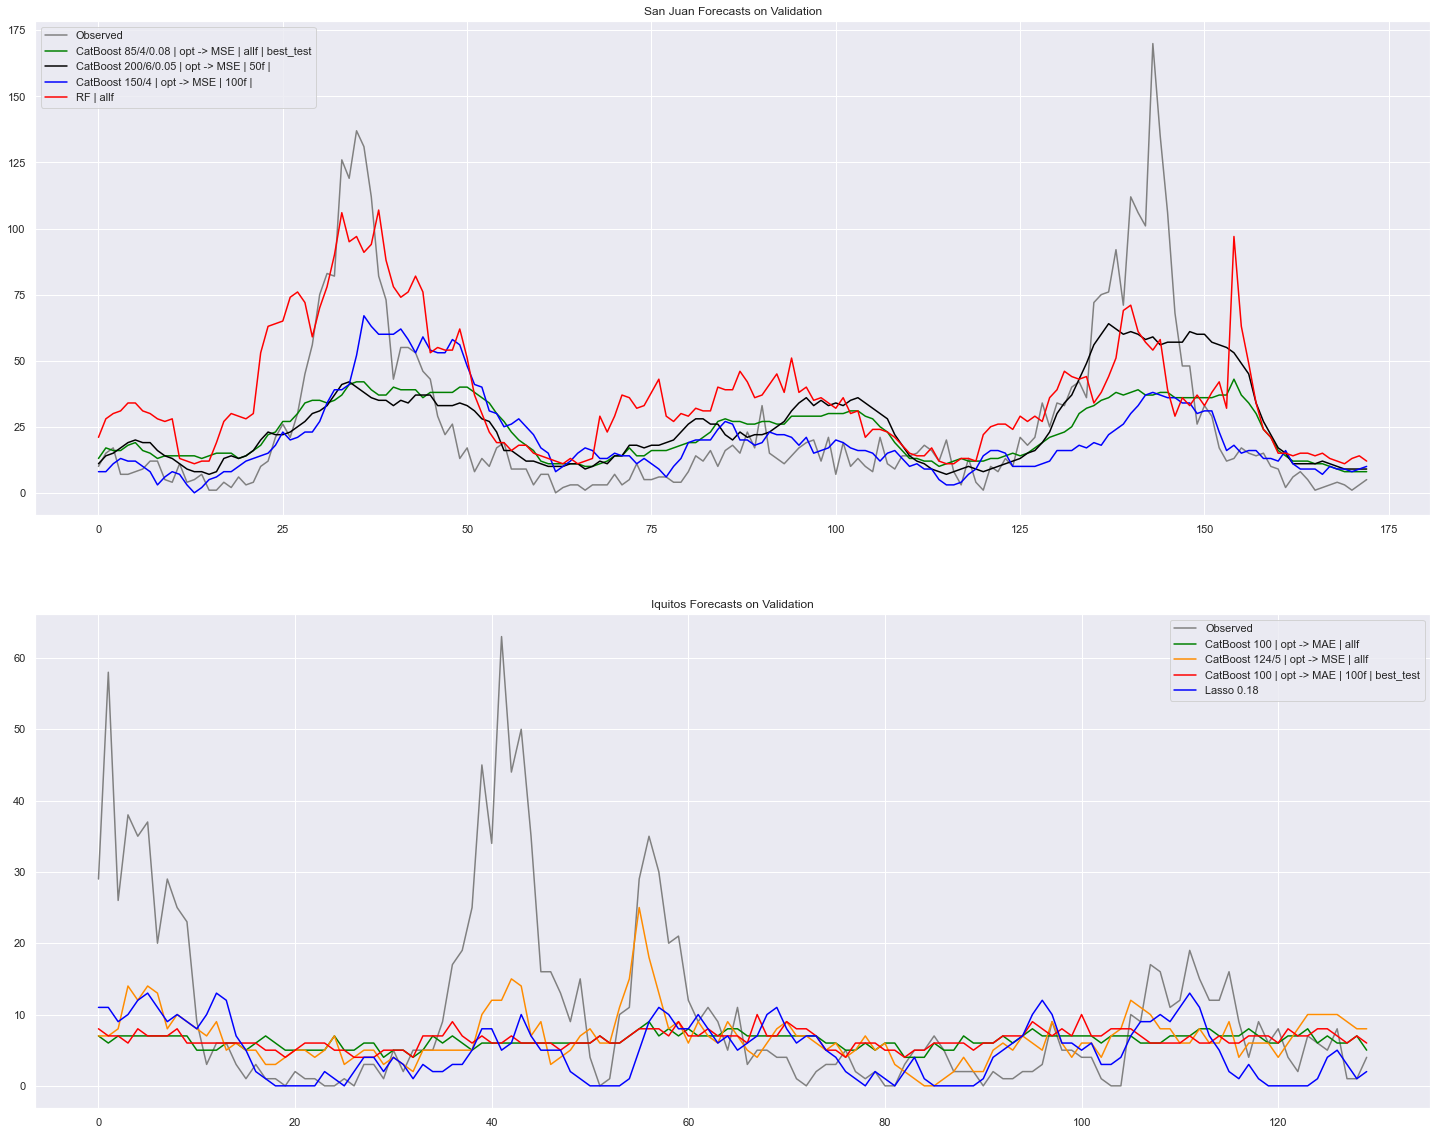

In [230]:
fig, axs = plt.subplots(2, figsize=(25, 20))  
axs[0].plot(TRAIN_SJ.loc[TRAIN_SJ['sample']=='test', 'target'].reset_index(drop=True), label='Observed', color='grey')

axs[0].plot(y_hat_cat_sj_val1, label='CatBoost 85/4/0.08 | opt -> MSE | allf | best_test', color='green')
axs[0].plot(y_hat_cat_sj_val2, label='CatBoost 200/6/0.05 | opt -> MSE | 50f |', color='black')
axs[0].plot(y_hat_cat_sj_val3, label='CatBoost 150/4 | opt -> MSE | 100f |', color='blue')
axs[0].plot(y_hat_rf_sj_val1, label='RF | allf', color='red')

axs[0].set_title('San Juan Forecasts on Validation')
axs[0].legend()

axs[1].plot(TRAIN_IQ.loc[TRAIN_IQ['sample']=='test', 'target'].reset_index(drop=True), label='Observed', color='grey')

axs[1].plot(y_hat_cat_iq_val1, label='CatBoost 100 | opt -> MAE | allf', color='green')
axs[1].plot(y_hat_cat_iq_val2, label='CatBoost 124/5 | opt -> MSE | allf', color='darkorange') 
axs[1].plot(y_hat_cat_iq_val3, label='CatBoost 100 | opt -> MAE | 100f | best_test', color='red') 
axs[1].plot(y_hat_lasso_iq_val1, label='Lasso 0.18', color='blue') 

axs[1].set_title('Iquitos Forecasts on Validation')
axs[1].legend()

# Forecast on Test

## San Juan

In [42]:
# лучшая модель - на всех признаках
cat_model = CatBoostRegressor(iterations=85, depth=4, learning_rate=0.08,
                          verbose=1, loss_function='RMSE') 
cat_model.fit(TRAIN_SJ.drop(columns=['target','sample']), TRAIN_SJ['target'], verbose=0) 
predicts = []
for i in range(len(TEST_SJ)):
    predict = cat_model.predict(TEST_SJ.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(TEST_SJ)-1) and 'target_lag_1' in TEST_SJ.columns:
        TEST_SJ.loc[i+1, 'target_lag_1'] = (predict - mean_target_sj)/scale_target_sj
y_hat_cat_sj_test1 = [int(arr) if arr > 0 else 0 for arr in predicts] 
cat_sj_test1 = pd.Series(y_hat_cat_sj_test1)
cat_sj_test1.index = pd.RangeIndex(start=936, stop=936 + len(cat_sj_test1))

# <center> Влияние признаков на таргет 📊

- Посмотрим на значимые бустингом признаки, отберём топ50 лучших, построим их графики влияния на таргет:

In [28]:
fi = cat_model.get_feature_importance(prettified=True)
features_best50 = list(fi['Feature Id'][:50])
features_best100 = list(fi['Feature Id'][:100])
fi[:5]

Feature Id  Importances
0                           target_lag_1    80.216945
1              station_max_temp_c_mean_8     3.850396
2                        ndvi_sw_turns_4     1.199152
3                        ndvi_ne_turns_4     1.015684
4  reanalysis_precip_amt_kg_per_m2_max_8     0.992458

Из гистограмм уберём признак `target_lag_1`, он слишком значим для сравнительного анализа :)

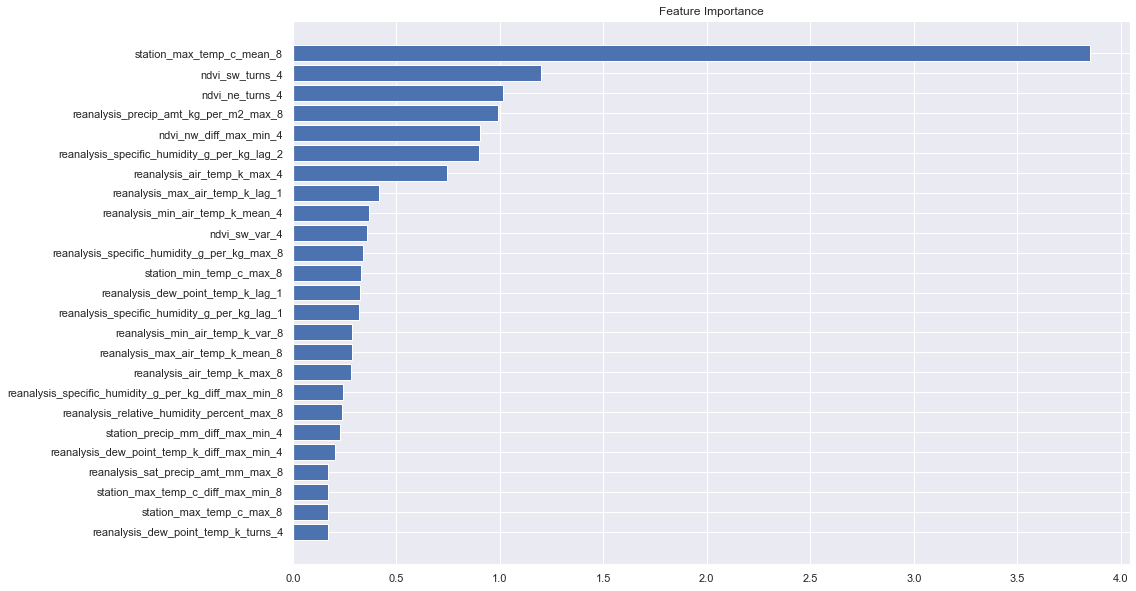

In [29]:
feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[235:-1]
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(TRAIN_SJ.drop(columns=['target','sample']).columns)[sorted_idx])
plt.title('Feature Importance');

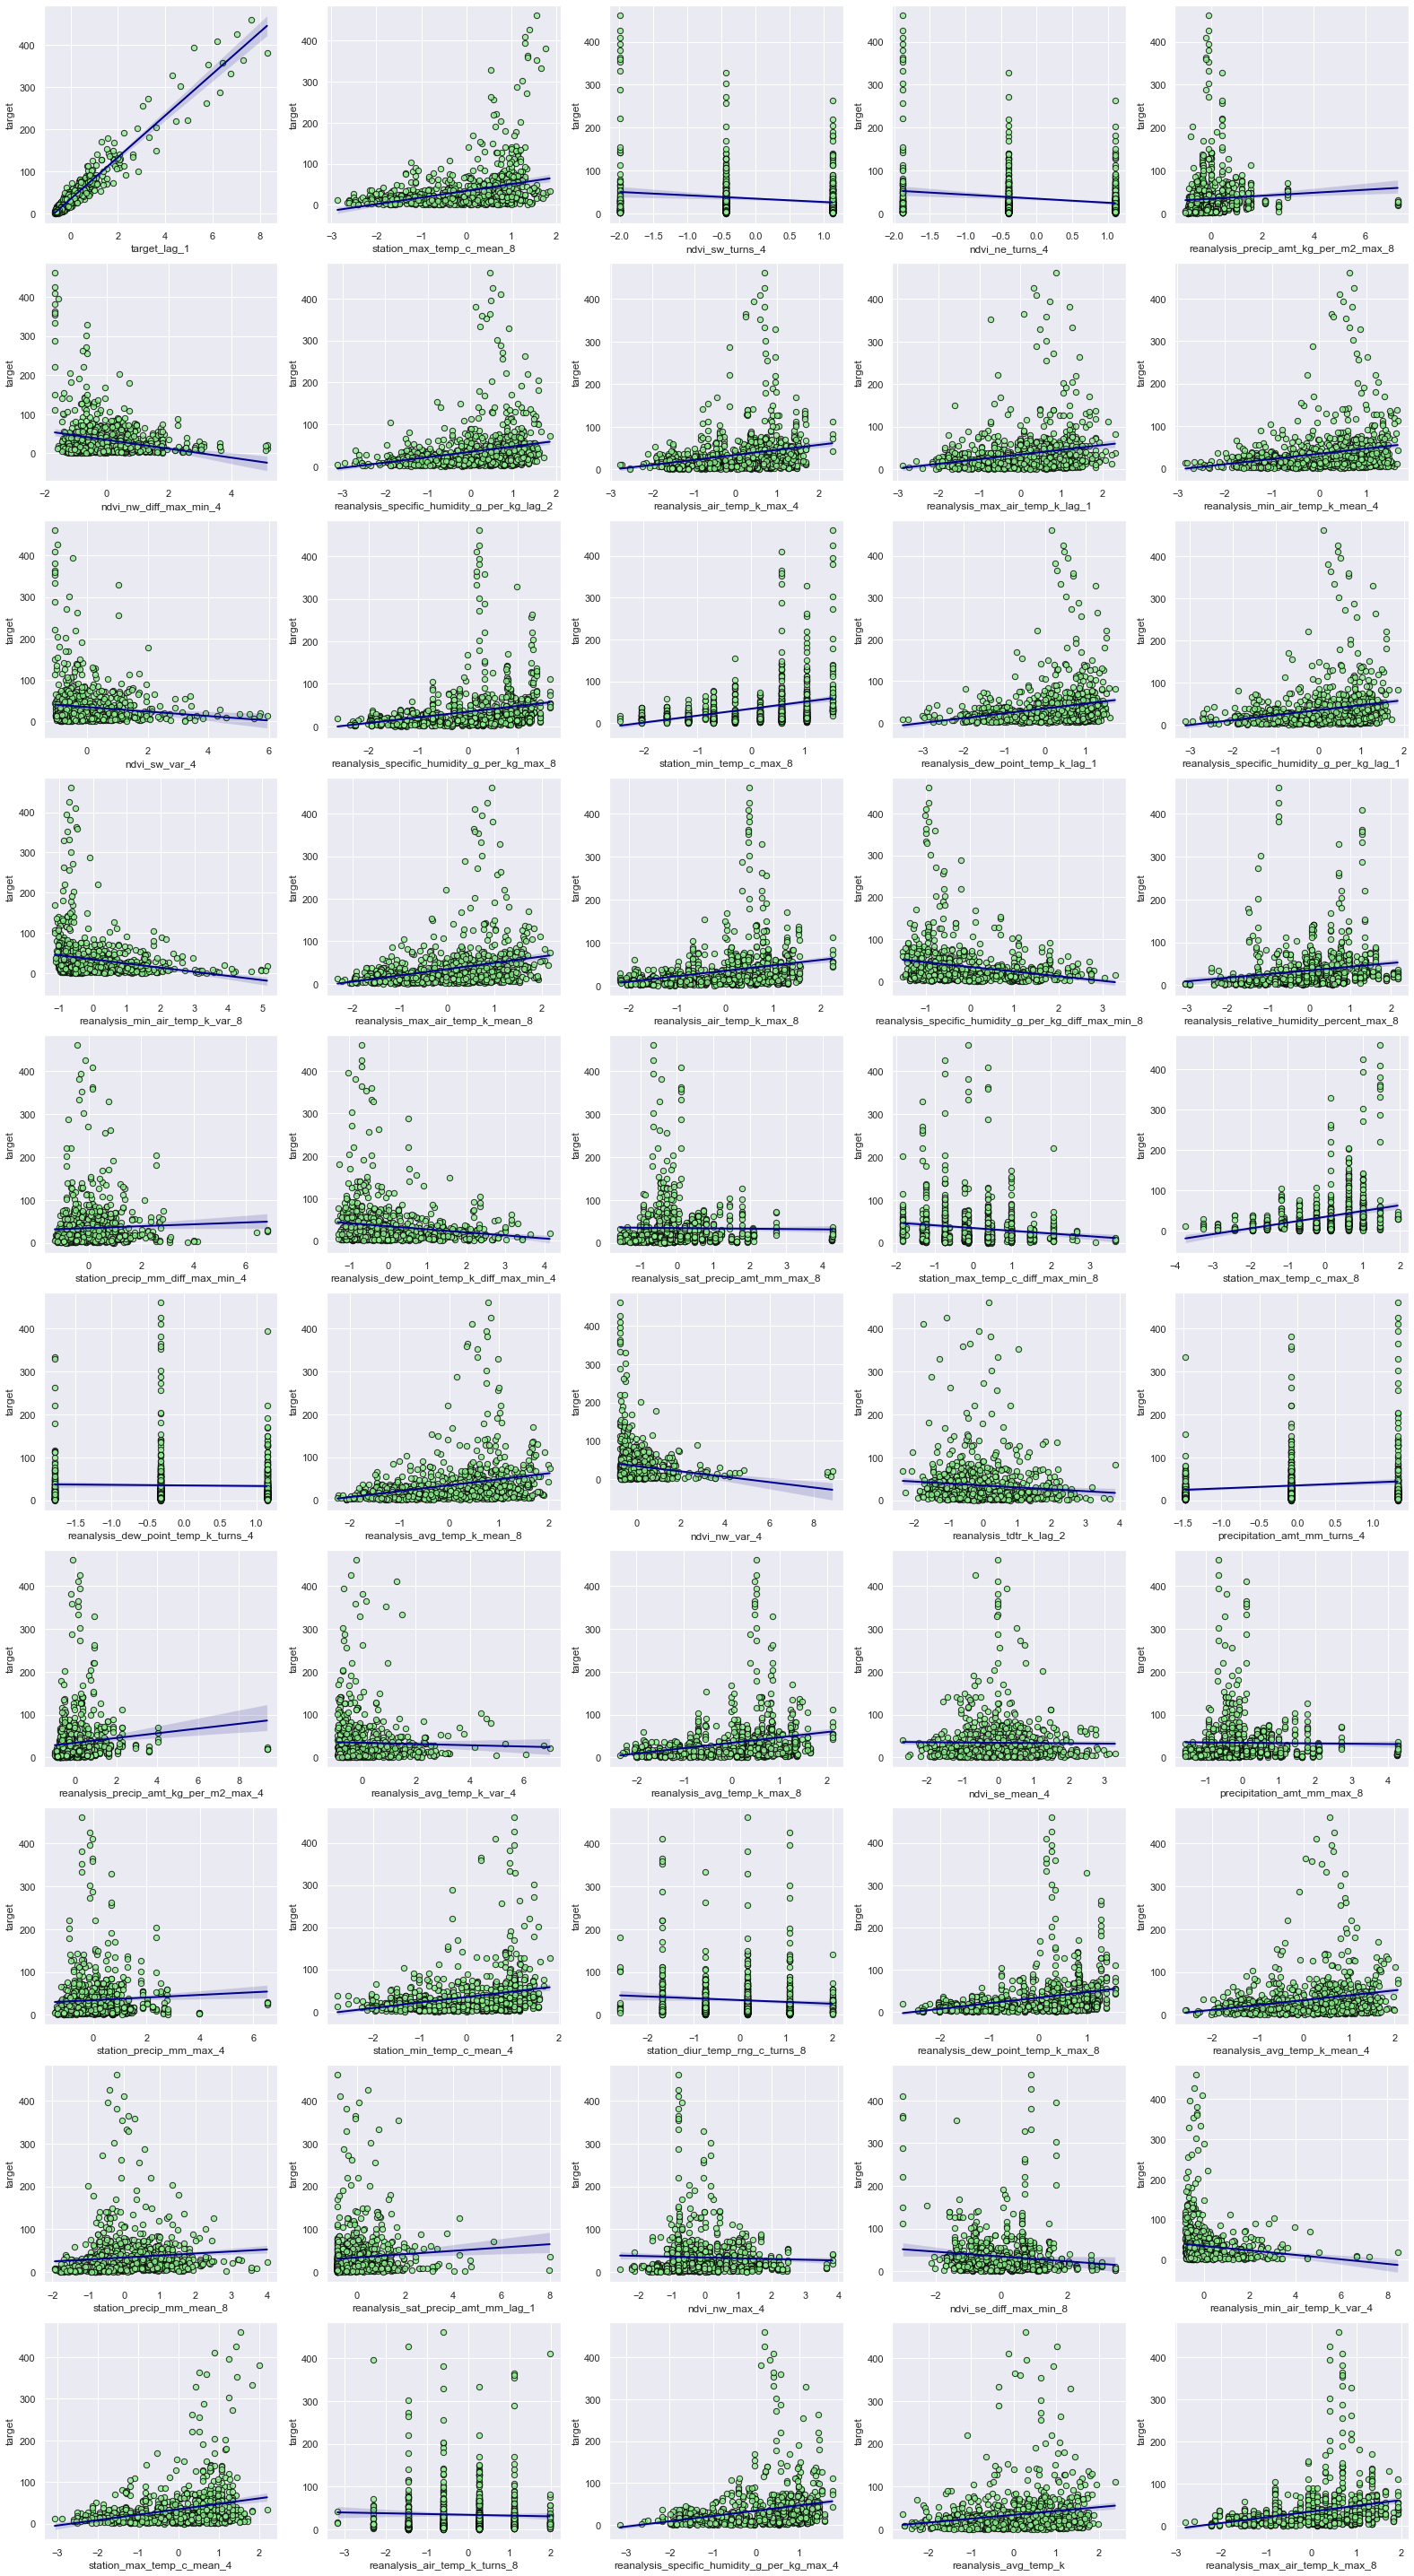

In [30]:
fig, axes = plt.subplots(10, 5, figsize=(22, 40))
axes = axes.flatten()  # Упрощаем работу с осями
base_color = 'blue'
for ax, feature in zip(axes, features_best50):
    sns.regplot(x=feature, y='target', data=TRAIN_SJ, ax=ax, color=base_color,
                scatter_kws={'color': 'lightgreen', 's': 40, 'edgecolor': 'black'},
                line_kws={'color': 'darkblue', 'linewidth': 2})  # Цвет и стиль линии
plt.tight_layout()  # Для лучшего расположения подграфиков
plt.show()

#### <center> ***Вывод, который можно сделать: линейные модели в данном случае не подойдут – они не смогут выжать максимум из данных, так как у некоторых признаков зависимости не линейны. На практике так и подтвердилось.***

In [44]:
# на 50 лучших признаках
cat_model2 = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.05,
                          verbose=1, loss_function='RMSE') 
cat_model2.fit(TRAIN_SJ[features_best50], TRAIN_SJ['target'], verbose=0, use_best_model=False, plot=False) #eval_set=eval_dataset 
predicts = []
for i in range(len(TEST_SJ)):
    predict = cat_model2.predict(TEST_SJ.loc[i:i, features_best50])[0]
    predicts.append(predict)
    if i != (len(TEST_SJ)-1) and 'target_lag_1' in TEST_SJ[features_best50].columns:
        TEST_SJ.loc[i+1, 'target_lag_1'] = (predict - mean_target_sj)/scale_target_sj
y_hat_cat_sj_test2 = [int(arr) if arr > 0 else 0 for arr in predicts] 
cat_sj_test2 = pd.Series(y_hat_cat_sj_test2)
cat_sj_test2.index = pd.RangeIndex(start=936, stop=936 + len(cat_sj_test2))

In [76]:
# на 100 лучших признаках 
cat_model3 = CatBoostRegressor(iterations=150, depth=4,
                          verbose=1, loss_function='RMSE') 
cat_model3.fit(TRAIN_SJ[features_best100], TRAIN_SJ['target'], verbose=0) 
predicts = []
for i in range(len(TEST_SJ)):
    predict = cat_model3.predict(TEST_SJ.loc[i:i, features_best100])[0]
    predicts.append(predict)
    if i != (len(TEST_SJ)-1) and 'target_lag_1' in TEST_SJ[features_best100].columns:
        TEST_SJ.loc[i+1, 'target_lag_1'] = (predict - mean_target_sj)/scale_target_sj
y_hat_cat_sj_test3 = [int(arr) if arr > 0 else 0 for arr in predicts] 
cat_sj_test3 = pd.Series(y_hat_cat_sj_test3)
cat_sj_test3.index = pd.RangeIndex(start=936, stop=936 + len(cat_sj_test3))

In [46]:
model = RandomForestRegressor(n_estimators=50, max_depth=6, min_samples_split=5,
                              min_samples_leaf=1, max_features='log2', random_state=777)
model.fit(TRAIN_SJ.drop(columns=['target','sample']), TRAIN_SJ['target'])

predicts = []
for i in range(len(TEST_SJ)):
    predict = model.predict(TEST_SJ.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(TEST_SJ)-1) and 'target_lag_1' in TEST_SJ.columns:
        TEST_SJ.loc[i+1, 'target_lag_1'] = (predict - mean_target_sj)/scale_target_sj
y_hat_rf_sj_test1 = [int(arr) if arr > 0 else 0 for arr in predicts] 
rf_sj_test1 = pd.Series(y_hat_rf_sj_test1)
rf_sj_test1.index = pd.RangeIndex(start=936, stop=936 + len(rf_sj_test1))

## Iquitos

In [85]:
model = CatBoostRegressor(iterations=100, 
                          verbose=1, loss_function='MAE') 
model.fit(TRAIN_IQ.drop(columns=['target','sample']), TRAIN_IQ['target'], verbose=0) 

predicts = []

for i in range(len(TEST_IQ)):
    predict = model.predict(TEST_IQ.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(TEST_IQ)-1) and 'target_lag_1' in TEST_IQ.columns:
        TEST_IQ.loc[i+1, 'target_lag_1'] = (predict - mean_target_iq)/scale_target_iq
        
y_hat_cat_iq_test1 = [int(arr) if arr > 0 else 0 for arr in predicts] 

cat_iq_test1 = pd.Series(y_hat_cat_iq_test1)
cat_iq_test1.index = pd.RangeIndex(start=518, stop=518 + len(cat_iq_test1))

# <center> Влияние признаков на таргет 📊

In [86]:
fi = model.get_feature_importance(prettified=True)
features_best50_iq = list(fi['Feature Id'][:50])
features_best100_iq = list(fi['Feature Id'][:100])
fi[:5]

Feature Id  Importances
0                        target_lag_1    44.031369
1     reanalysis_max_air_temp_k_max_8     1.579487
2  reanalysis_sat_precip_amt_mm_max_8     1.474691
3                     ndvi_se_turns_4     1.123750
4     station_diur_temp_rng_c_turns_8     0.999013

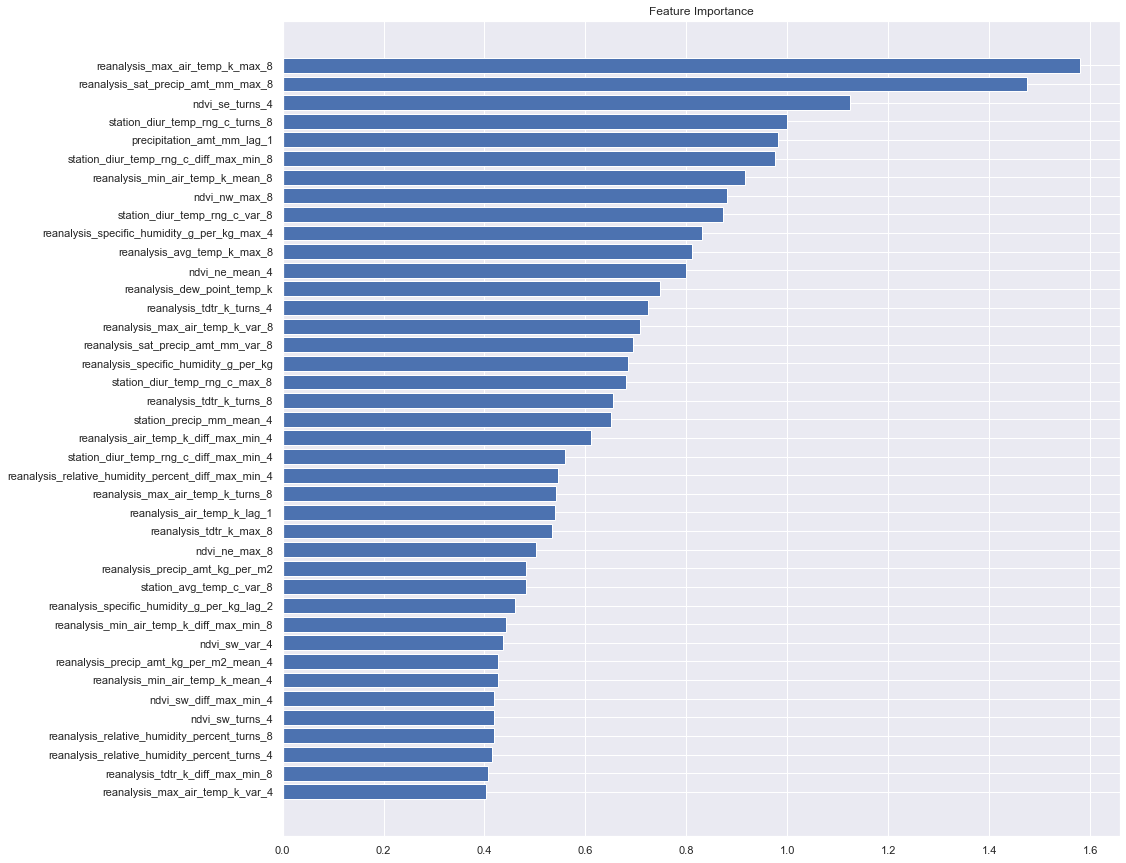

In [99]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[220:-1]
fig = plt.figure(figsize=(15, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(TRAIN_IQ.drop(columns=['target','sample']).columns)[sorted_idx])
plt.title('Feature Importance');

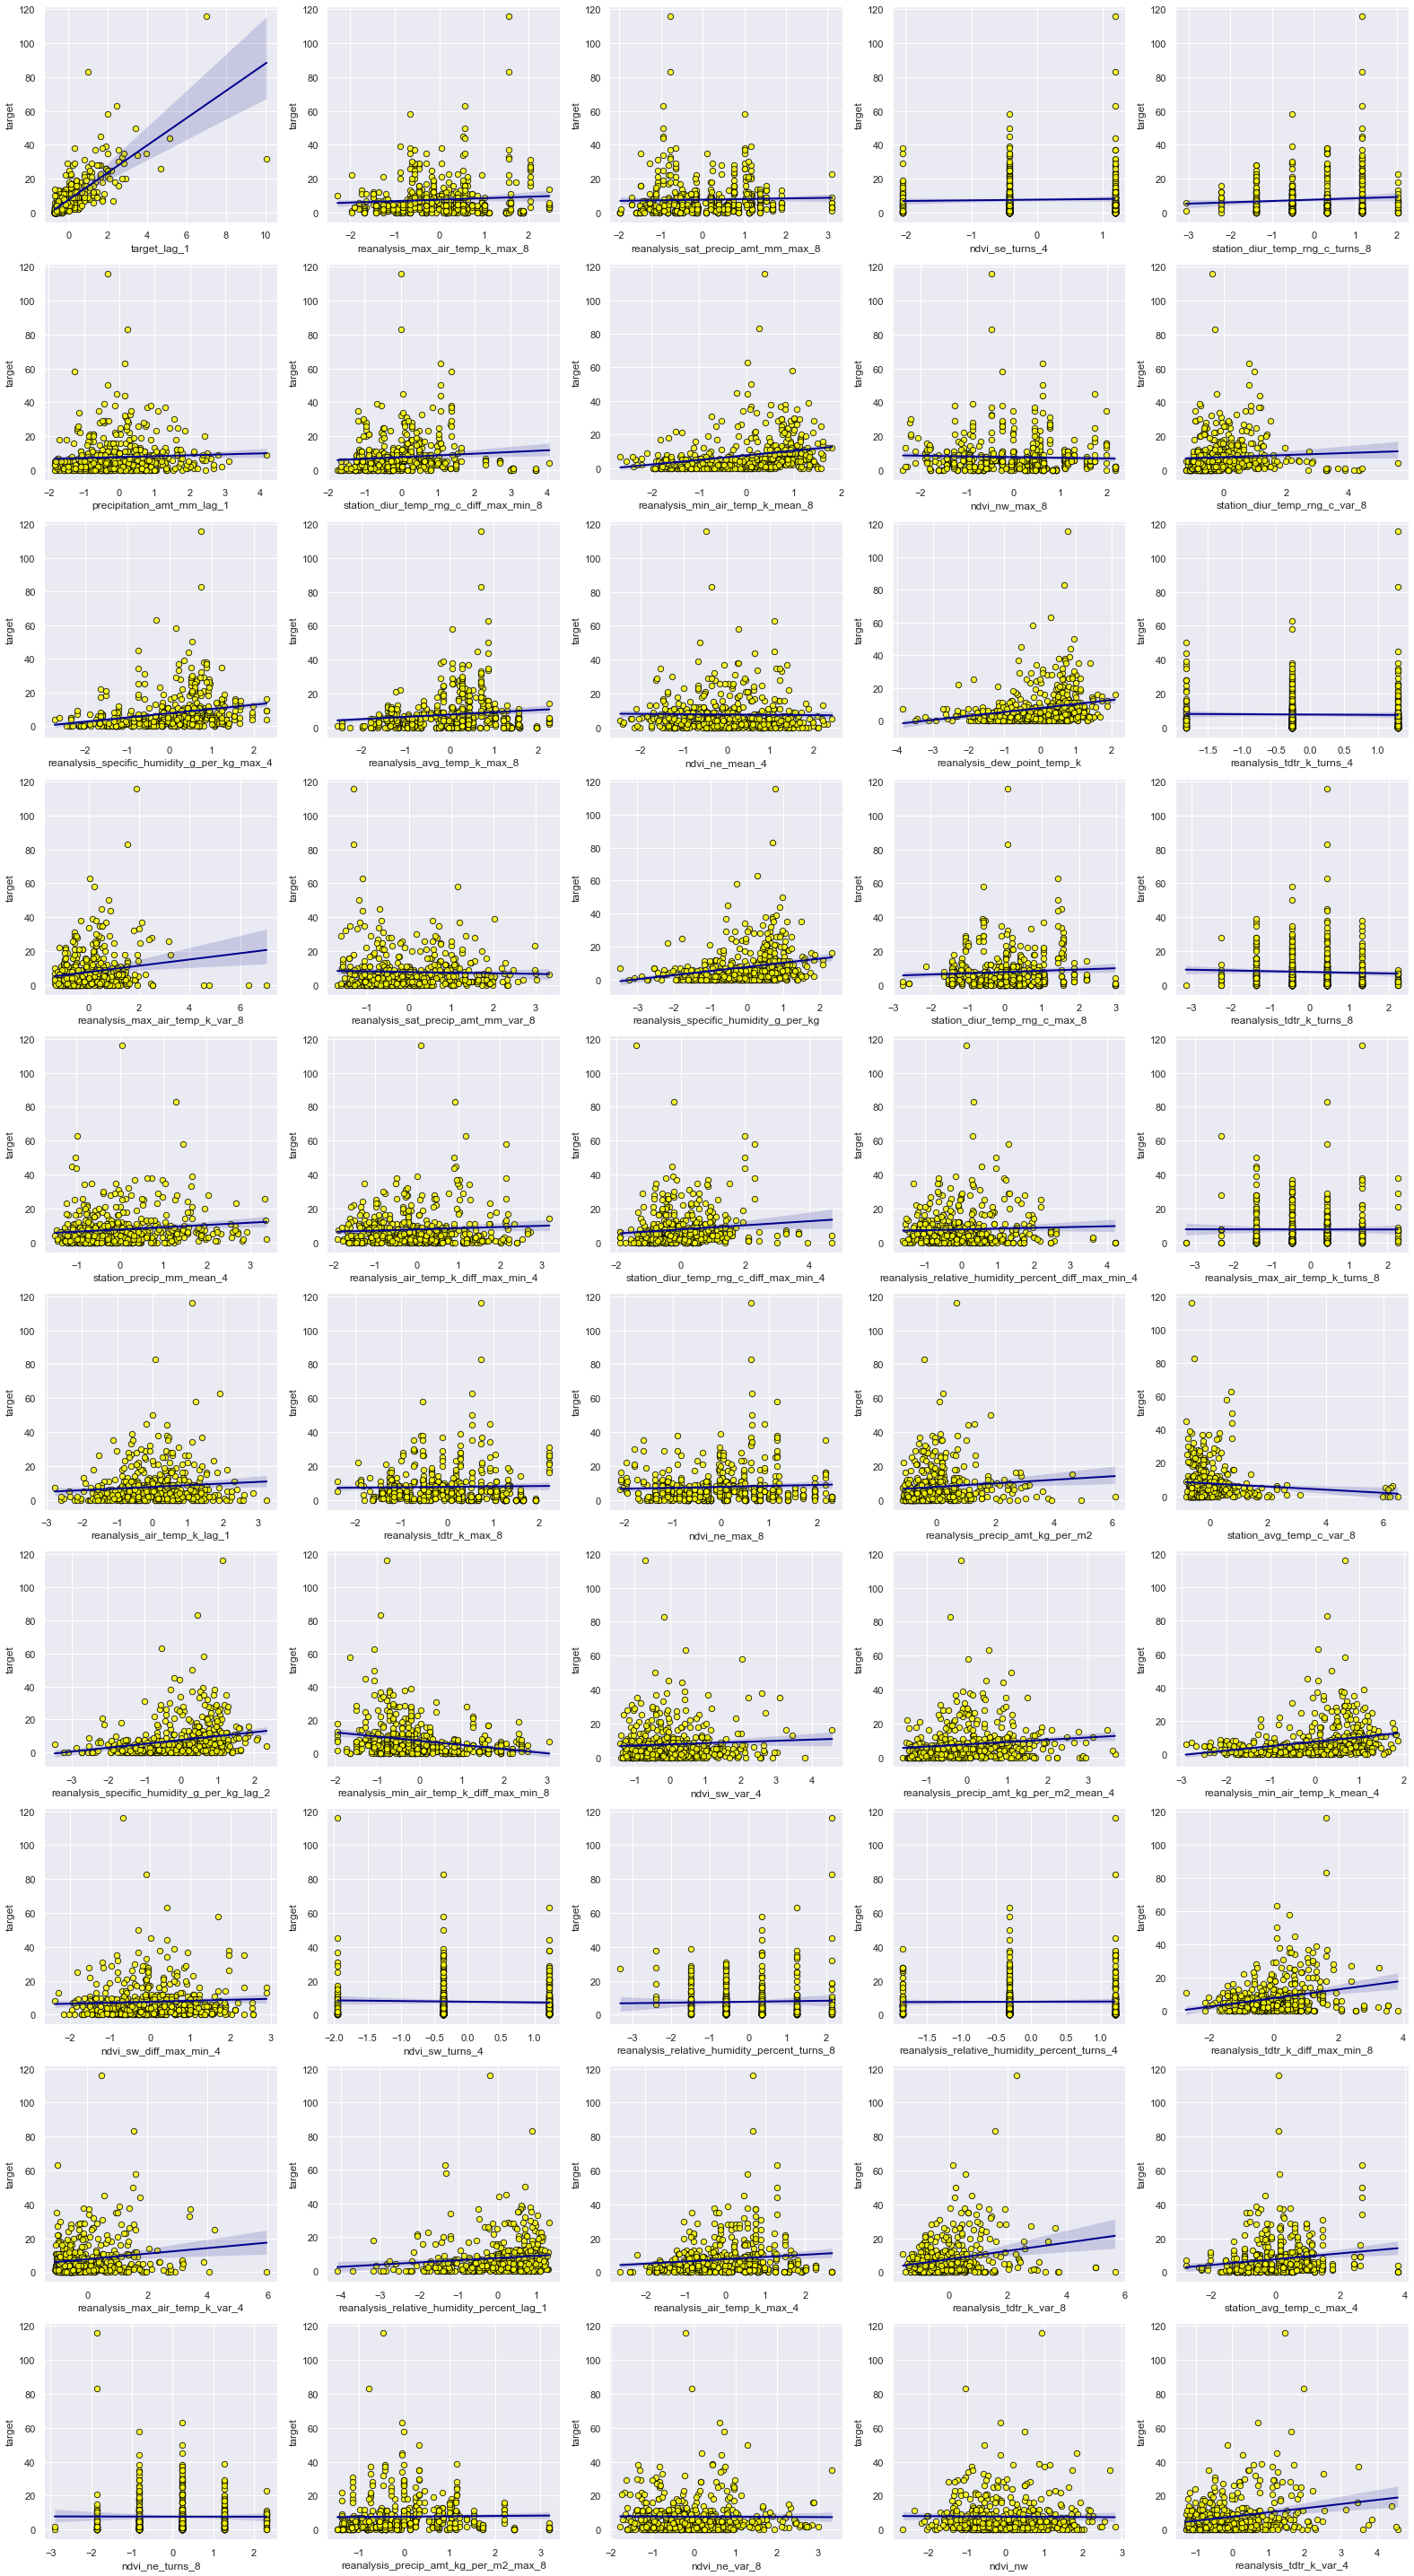

In [102]:
fig, axes = plt.subplots(10, 5, figsize=(22, 40))
axes = axes.flatten()  # Упрощаем работу с осями
base_color = 'blue'
for ax, feature in zip(axes, features_best50_iq):
    sns.regplot(x=feature, y='target', data=TRAIN_IQ, ax=ax, color=base_color,
                scatter_kws={'color': 'yellow', 's': 40, 'edgecolor': 'black'},
                line_kws={'color': 'darkblue', 'linewidth': 2})  # Цвет и стиль линии
plt.tight_layout()  # Для лучшего расположения подграфиков
plt.show()

In [81]:
# лучший по валидации CatBoostRegressor
model = CatBoostRegressor(iterations=125, depth=5, 
                          verbose=1, loss_function='RMSE') 
model.fit(TRAIN_IQ.drop(columns=['target','sample']), TRAIN_IQ['target'], verbose=0) 

predicts = []

for i in range(len(TEST_IQ)):
    predict = model.predict(TEST_IQ.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(TEST_IQ)-1) and 'target_lag_1' in TEST_IQ.columns:
        TEST_IQ.loc[i+1, 'target_lag_1'] = (predict - mean_target_iq)/scale_target_iq

y_hat_cat_iq_test2 = [int(arr) if arr > 0 else 0 for arr in predicts] 

cat_iq_test2 = pd.Series(y_hat_cat_iq_test2)
cat_iq_test2.index = pd.RangeIndex(start=518, stop=518 + len(cat_iq_test2))

In [113]:
# лучшая модель на тесте
model = CatBoostRegressor(iterations=100, verbose=1, loss_function='MAE') 
model.fit(TRAIN_IQ[features_best100_iq], TRAIN_IQ['target'], verbose=0) 

predicts = []

for i in range(len(TEST_IQ[features_best100_iq])):
    predict = model.predict(TEST_IQ.loc[i:i, features_best100_iq])[0]
    predicts.append(predict)
    if i != (len(TEST_IQ[features_best100_iq])-1) and 'target_lag_1' in TEST_IQ[features_best100_iq].columns:
        TEST_IQ.loc[i+1, 'target_lag_1'] = (predict - mean_target_iq)/scale_target_iq

y_hat_cat_iq_test3 = [int(arr) if arr > 0 else 0 for arr in predicts] 

cat_iq_test3 = pd.Series(y_hat_cat_iq_test3)
cat_iq_test3.index = pd.RangeIndex(start=518, stop=518 + len(cat_iq_test3))

In [82]:
model = linear_model.Lasso(alpha=0.18, max_iter=1000)
model.fit(TRAIN_IQ.drop(columns=['target','sample']), TRAIN_IQ['target'])

predicts = []
for i in range(len(TEST_IQ)):
    predict = model.predict(TEST_IQ.loc[i:i, :])[0]
    predicts.append(predict)
    if i != (len(TEST_IQ)-1) and 'target_lag_1' in TEST_IQ.columns:
        TEST_IQ.loc[i+1, 'target_lag_1'] = (predict - mean_target_iq)/scale_target_iq
y_hat_lasso_iq_test1 = [int(arr) if arr > 0 else 0 for arr in predicts] 

lasso_iq_test1 = pd.Series(y_hat_lasso_iq_test1)
lasso_iq_test1.index = pd.RangeIndex(start=518, stop=518 + len(lasso_iq_test1))

# Visualization of Forecast on Test

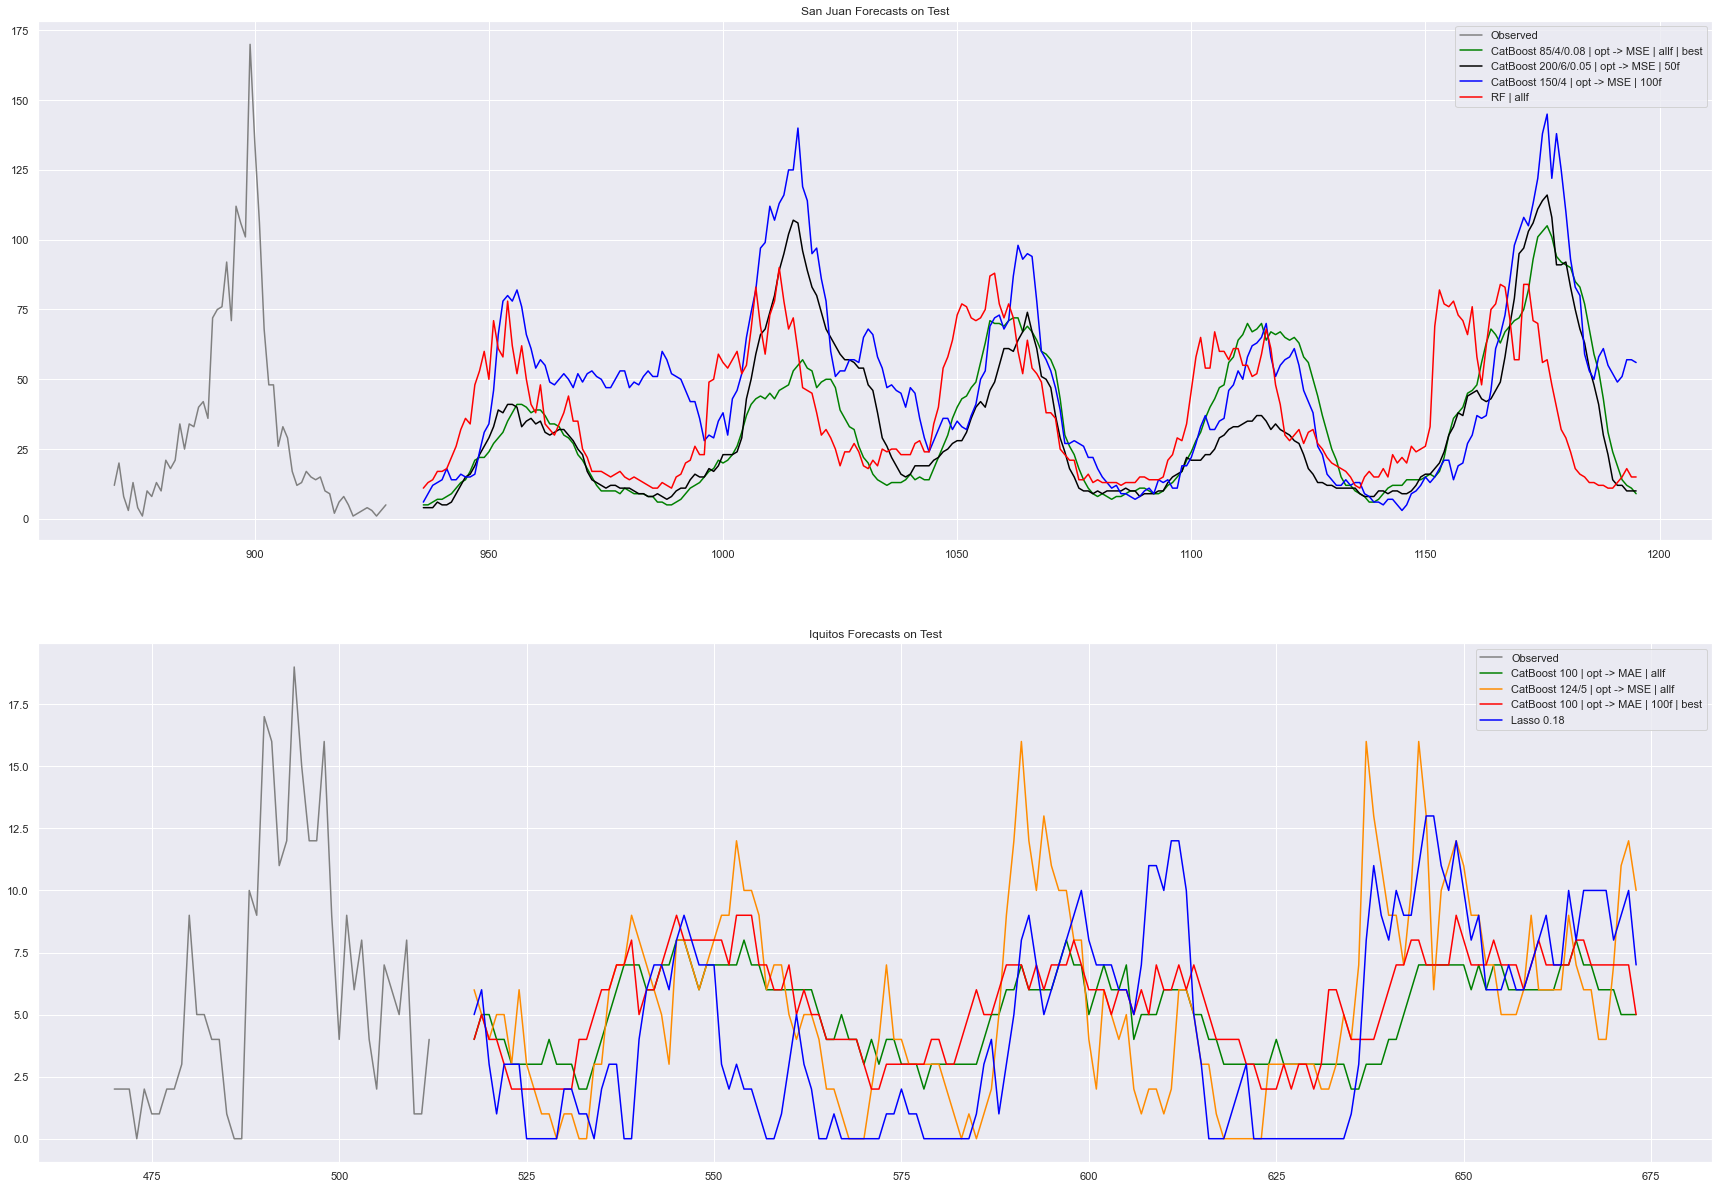

In [227]:
fig, axs = plt.subplots(2, figsize=(30, 21))  
axs[0].plot(TRAIN_SJ['target'][870:], label='Observed', color='grey')
axs[0].plot(cat_sj_test1, label='CatBoost 85/4/0.08 | opt -> MSE | allf | best', color='green')
axs[0].plot(cat_sj_test2, label='CatBoost 200/6/0.05 | opt -> MSE | 50f', color='black')
axs[0].plot(cat_sj_test3, label='CatBoost 150/4 | opt -> MSE | 100f', color='blue')
axs[0].plot(rf_sj_test1, label='RF | allf ', color='red')

axs[0].set_title('San Juan Forecasts on Test')
axs[0].legend()

axs[1].plot(TRAIN_IQ['target'][470:], label='Observed', color='grey')
axs[1].plot(cat_iq_test1, label='CatBoost 100 | opt -> MAE | allf', color='green')
axs[1].plot(cat_iq_test2, label='CatBoost 124/5 | opt -> MSE | allf', color='darkorange') 
axs[1].plot(cat_iq_test3, label='CatBoost 100 | opt -> MAE | 100f | best', color='red') 
axs[1].plot(lasso_iq_test1, label='Lasso 0.18', color='blue')  

axs[1].set_title('Iquitos Forecasts on Test')
axs[1].legend()

# Conclusions 🌚
- - Для города **San Juan** оказалась важна оптимизируемая функция потерь. **Минимизировать было оптимальнее `RMSE`**, так как у этого города **заболеваемость имеет ярко выраженные высокие значения в сезоны**. `RMSE` подходит больше, чем и `MAE`, потому что он больше штрафует модель за сильные отклонения в сезонные промежутки заболеваемости. Таким образом, модель учится видеть вспышки болезней. Также, качество прогнозирования выше, если **обучаться на всех признаках**. 
  - **Лучшая модель**: `CatBoostRegressor` с параметрами `iterations=85`, `depth=4`, `learning_rate=0.08`, `loss_function='RMSE'` на всём признаковом пространстве.
<br><br>
- - Для города **Iquitos** наоборот: было оптимизировано `MAE`, так как заболеваемость не имеет сильно выраженных пиков. Качество выше при обучении на 100 лучших признаках по важности. 
  - **Лучшая модель**: `CatBoostRegressor` с параметрами `iterations=100`, `depth=6`, `loss_function='MAE'` на 100 признаках.
<br><br>
- - Существует множество направлений **для дальнейшего анализа**:  
    - Попробовать другие подходы и **методы валидации**
    - Придумать **новые признаки** на основе имеющихся
    - Обучить **более сложные модели**: например рекуррентные нейронные сети `RNN`/`LSTM`

# Submission 🐿️

In [128]:
sub_df = test.iloc[:,:3]  
answers = list(cat_sj_test1)+list(cat_iq_test3)
sub_df['total_cases'] = answers
data = pd.DataFrame(sub_df).to_csv('subs/best_predict.csv', sep=',', index=False)

# Rank 🏆

Итоговый результат: качество прогнозирования по **`MAE = 21.29`, занятое место = 436 (всего участников 15208**)

<img src='images/rank.png' />

---------
